In [1]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# info tables
infotable = f'/data01/homes/dipiano/E4/irf_random/crab/sim/merged_simulator_data.dat'

# dataset 
mapsname = '/data01/homes/dipiano/E4/irf_random/crab/regressor_100s_5sgm_5000sz_200x200_YESnorm_NOstretch.npy'
ds = np.load(mapsname, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
print(f"Maps: {ds.keys()}")
print(f"DS dataset size: {len(ds['DS'])}")

Maps: dict_keys(['DS', 'LABELS', 'SEED', 'SOURCE', 'FILE', 'EXPOSURE'])
DS dataset size: 5000


In [2]:
from astroai.tools.utils import split_regression_dataset

binning = 200
train_data, train_labels, test_data, test_labels = split_regression_dataset(ds, split=80, reshape=True, 
                                                                            binning=binning)

print(f"Train dataset: {len(train_data)}, {train_data.shape}")
print(f"Train labels: {len(train_labels)}, {train_labels.shape}")
print(f"\nTest dataset: {len(test_data)}, {test_data.shape}")
print(f"Test labels: {len(test_labels)}, {test_labels.shape}")

(4000, 200, 200) (4000, 2)
Train dataset: 4000, (4000, 200, 200, 1)
Train labels: 4000, (4000, 2)

Test dataset: 1000, (1000, 200, 200, 1)
Test labels: 1000, (1000, 2)


In [3]:
import numpy as np
from astroai.tools.utils import plot_heatmap, set_wcs

# get random seed
idx = np.random.choice(range(len(test_data)))
# find seed to get the original heatmap
seed = len(train_data) + idx + 1

# get simulation data
infodata = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
row = infodata[infodata['seed']==seed]
row

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
19329,crab_04330,4330,0,100,100,64.684764,52.578381,63.765371,51.589844,1.138572,North_z40_N_0.5h_LST,2.5,7.021451


# Load model and weights

In [4]:
import tensorflow as tf

savename = 'regressor_200x200_filter2_90kp' 
model = tf.keras.models.load_model(f'../models/{savename}.keras')
model.summary()

2024-02-07 17:05:10.663752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-07 17:05:10.847164: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-07 17:05:10.847193: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-02-07 17:05:11.612213: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 197, 197, 2)       34        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 2)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 4)         36        
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 4)         68        
                                                                 
 conv2d_3 (Conv2D)           (None, 95, 95, 4)         68        
                                                                 
 conv2d_4 (Conv2D)           (None, 94, 94, 4)         68        
                                                        

32/32 [==============================] - 1s 17ms/step


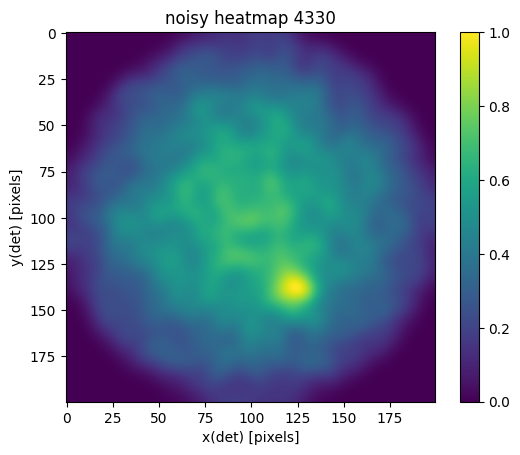

array([1., 1.], dtype=float32)

In [8]:
predictions = model.predict(test_data)

# plot noisy and prediction
plot_heatmap(test_data[idx], title=f'noisy heatmap {seed}', show=True, save=False, save_name=None)
predictions[idx]

### Check WCS to pixel conversion

In [9]:
from astroai.tools.utils import *

w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=binning/2+0.5, pixelsize=2*row['fov'].values[0]/250)
x, y = w.world_to_pixel(SkyCoord(row['source_ra'].values[0], row['source_dec'].values[0], unit='deg'))
x, y

(array(71.57193568), array(149.11250396))

In [10]:
sky = w.pixel_to_world(x, y)
sky

<SkyCoord (ICRS): (ra, dec) in deg
    (64.68476406, 52.57838125)>

# Plot loss

In [12]:
loss = model.evaluate(test_data, test_labels, verbose=2)

32/32 - 1s - loss: 97.1464 - accuracy: 0.4940 - 804ms/epoch - 25ms/step


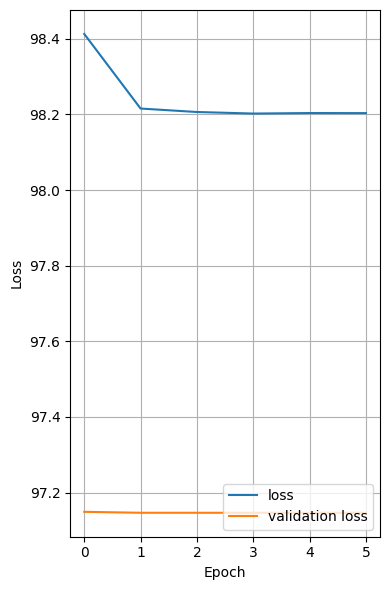

In [14]:
import matplotlib.pyplot as plt

history = np.load(f'/data01/homes/dipiano/astroAI/astroai/models/{savename}_history.npy', 
                  allow_pickle='TRUE').item()


fig, ax = plt.subplots(figsize=(4, 6))

ax.plot(history['loss'], label='loss')
ax.plot(history['val_loss'], label = 'validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
#ax.set_ylim([0.2,0.65])
ax.grid()
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()